# Differentiable Physics Application

Source: https://scipython.com/blog/the-brachistochrone-problem/

# Approximating the Brachistochrone Curve with a Neural Network

## Problem Statement

I want to approximate the curve \( y = f(x) \) using a neural network. To do so, I need a physics-based model to define my loss function. The loss will be the total time taken by a ball to travel along the curve under gravity, and I will minimize this time.

## Physics Model

The time taken for the ball to travel along the curve is given by the integral:

$$ 
T = \int_0^L \frac{ds}{v} 
$$

where:

- \( L \) is the total arc length of the curve.
- \( ds \) is the differential arc length.
- \( v \) is the velocity of the ball.

---

### Conservation of Energy

The ball must obey the conservation of energy:

$$ 
\frac{1}{2} m v^2 = mg y 
$$

where:

- \( m \) is the mass of the ball.
- \( v \) is its velocity.
- \( g = 9.81 \, m/s^2 \) is the gravitational acceleration.



Rearranging for \( v \):

$$ 
v = \sqrt{2 g y} 
$$

Substituting this into the time integral:

$$ 
T = \int_0^L \frac{ds}{\sqrt{2 g y}} 
$$

### Arc Length Differential

From differential geometry, the arc length element \( ds \) satisfies:

$$ 
ds^2 = dx^2 + dy^2 
$$

**Why?** This comes from the Pythagorean theorem applied to an infinitesimal segment of the curve.

Thus, we substitute:

$$ 
ds = \sqrt{dx^2 + dy^2} 
$$

So the final integral for time becomes:

$$ 
T = \int_0^L \frac{\sqrt{dx^2 + dy^2}}{\sqrt{2 g y}} 
$$

This integral will serve as the loss function for training the neural network.

## Loss Function for the Neural Network

To approximate the brachistochrone curve, we define our loss function \( L(\theta) \) as the total time taken by the ball to travel along the learned curve. This function is based on the time integral we derived earlier, but now we replace \( y \) with the output of the neural network \( \text{NN}(x, \theta) \), which represents the learned curve.

### Loss Function Definition

$$
L(\theta) = \int_0^L \frac{\sqrt{dx^2 + dy^2}}{\sqrt{2 g y}}
$$

Substituting \( y = \text{NN}(x, \theta) \), we obtain:

$$
L(\theta) = \int_0^L \frac{\sqrt{dx^2 + d(\text{NN}(x, \theta))^2}}{\sqrt{2 g \, \text{NN}(x, \theta)}}
$$


This loss function is minimized during training to find the optimal parameters \( \theta \) that yield the fastest descent path.


In [5]:
import torch
import torch.nn as nn
import scipy.optimize
import matplotlib.pyplot as plt
from scipy.optimize import newton
import numpy as np
import matplotlib.animation as animation


In [6]:

def cycloid(x2, y2):
    """Return the path of Brachistochrone curve from (0,0) to (x2, y2).

    The Brachistochrone curve is the path down which a bead will fall without
    friction between two points in the least time (an arc of a cycloid).
    It is returned as an array of N values of (x,y) between (0,0) and (x2,y2).

    """

    def f(theta):
        return y2/x2 - (1-np.cos(theta))/(theta-np.sin(theta))
    theta2 = newton(f, np.pi/2)

    R = y2 / (1 - np.cos(theta2))
    return R, theta2


In [ ]:
import torch
import torch.nn as nn

class NN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()

        activation = nn.Tanh

        self.fcs = nn.Sequential(
            nn.Linear(N_INPUT, N_HIDDEN),
            activation()
        )

        self.fch = nn.Sequential(
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()),
            nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()),

        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x, x2, y2):
        """
        Forward pass: computes the output y given input x.
        The model approximates the Brachistochrone curve by combining:
        1. A linear component (simple interpolation)
        2. A residual component (learned by the NN)
        """
        # **1. Compute the linear part** (simple interpolation)
        y_linear = (y2 / x2) * x

        # **2. Compute the residual part** (learned by the NN)
        residual_input = x - x2 / 2  
        hidden = self.fcs(residual_input)  
        hidden = self.fch(hidden)          
        y_residual = self.fce(hidden)      

        # **3. Combine both components**
        y = y_linear + torch.tanh(x) * torch.tanh(x - x2) * y_residual

        return y


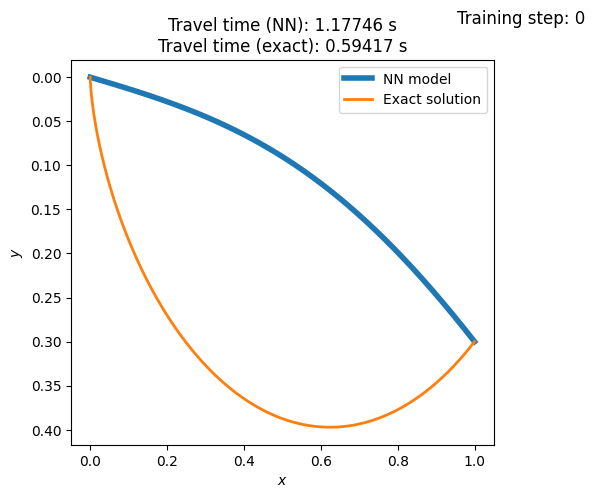

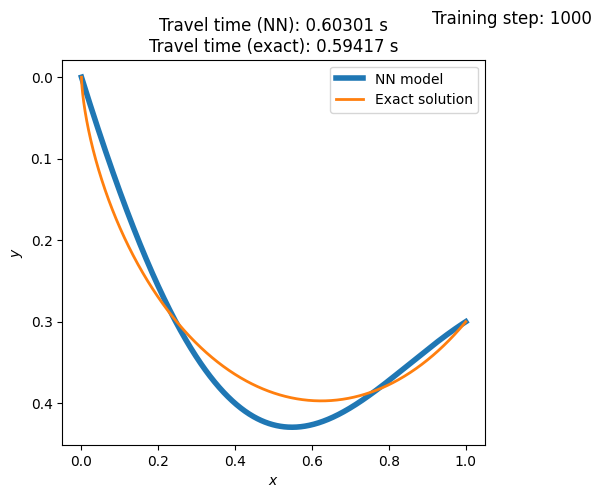

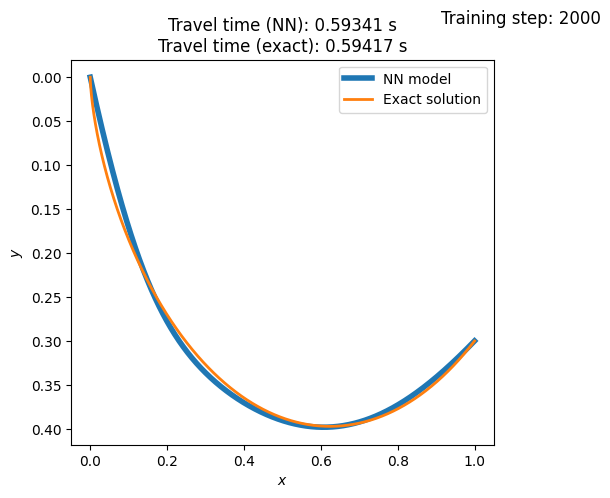

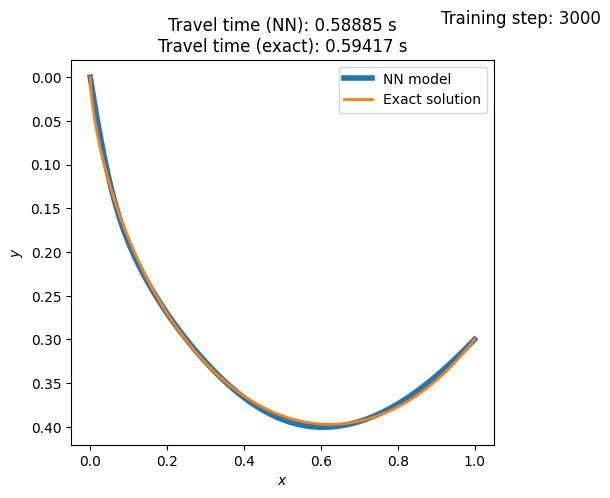

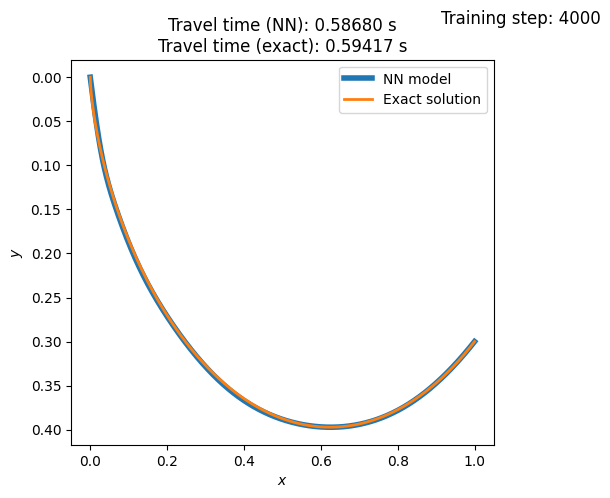

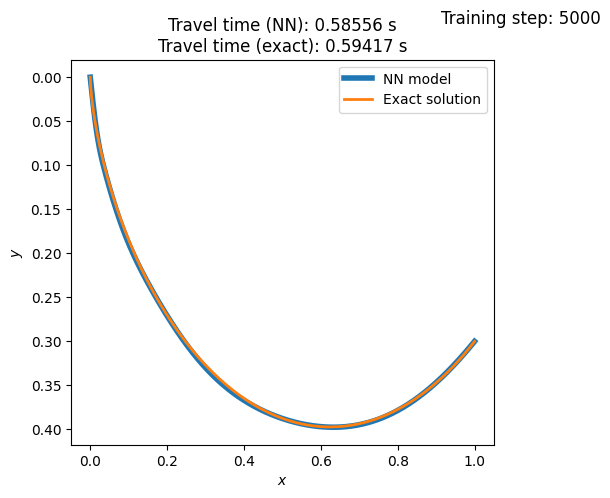

In [ ]:
x2,y2 = 1, 0.3
g = 9.81

model = NN(1,1,10)

n = 10000
dx = x2/n
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for it in range(5001):
    optimizer.zero_grad()  
    x = dx* torch.arange(1,n+1,dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    y = model(x, x2, y2)
    dy_dx = torch.autograd.grad(y, x, torch.ones_like(x), create_graph=True)[0]
    f = torch.sqrt((1 + dy_dx**2)/(2 * g * y))
    loss = torch.trapz(f, x,dim=0)
    loss.backward()
    optimizer.step()                                
    
    if it % 1000 == 0:  #
        x = torch.linspace(0, 1, 1000, requires_grad=True).reshape(-1, 1)
        y = model(x, x2, y2).detach().numpy()[:, 0]
        R, theta2 = cycloid(x2, y2)
        theta = np.linspace(0, theta2, 1000)
        x_true = R * (theta - np.sin(theta))
        y_true = R * (1 - np.cos(theta))    

        t_true = theta2 * np.sqrt(R / g)

        plt.figure(figsize=(12, 5))
        plt.suptitle(f"Training step: {it}")

        plt.subplot(1, 2, 1)
        plt.title(f"Travel time (NN): {loss.item():.5f} s\nTravel time (exact): {t_true:.5f} s")
        plt.plot(x.detach().numpy()[:, 0], y, linewidth=4, label="NN model")
        plt.plot(x_true, y_true, linewidth=2, label="Exact solution")

        ylim = plt.ylim()
        plt.ylim(ylim[1], ylim[0])  
        plt.xlabel("$x$")
        plt.ylabel("$y$")
        plt.legend()

        
        plt.show()

       
